In [2]:
from keras.models import load_model
import glob
from keras.models import Sequential
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from numpy import expand_dims
import matplotlib.pyplot as plt
import shutil
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import os
import cv2

Using TensorFlow backend.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import pandas as pd
df = pd.read_csv("/content/drive/Shared drives/선빵팀 :) 2/inner_woong.csv")
Criteria = df.to_dict("list")
for i in range(0,91):
  key = str(i)
  value_list = Criteria[key]
  value = round(value_list[0],4)
  Criteria[key] = value

In [4]:
Criteria

{'0': 0.8805,
 '1': 0.7943,
 '10': 0.8931,
 '11': 0.8362,
 '12': 0.8626,
 '13': 0.8589,
 '14': 0.8124,
 '15': 0.8599,
 '16': 0.8685,
 '17': 0.8547,
 '18': 0.868,
 '19': 0.9326,
 '2': 0.7979,
 '20': 0.8812,
 '21': 0.9068,
 '22': 0.8739,
 '23': 0.9225,
 '24': 0.8952,
 '25': 0.8679,
 '26': 0.9055,
 '27': 0.853,
 '28': 0.8722,
 '29': 0.7616,
 '3': 0.8536,
 '30': 0.8776,
 '31': 0.7188,
 '32': 0.7891,
 '33': 0.8247,
 '34': 0.9145,
 '35': 0.7548,
 '36': 0.7962,
 '37': 0.8493,
 '38': 0.8738,
 '39': 0.7702,
 '4': 0.7925,
 '40': 0.8306,
 '41': 0.8267,
 '42': 0.8539,
 '43': 0.838,
 '44': 0.8023,
 '45': 0.7547,
 '46': 0.7874,
 '47': 0.8152,
 '48': 0.7977,
 '49': 0.8735,
 '5': 0.9326,
 '50': 0.8192,
 '51': 0.9003,
 '52': 0.8694,
 '53': 0.8448,
 '54': 0.8533,
 '55': 0.8472,
 '56': 0.7429,
 '57': 0.7124,
 '58': 0.735,
 '59': 0.7731,
 '6': 0.772,
 '60': 0.8956,
 '61': 0.7543,
 '62': 0.8834,
 '63': 0.7667,
 '64': 0.8954,
 '65': 0.8467,
 '66': 0.9026,
 '67': 0.8078,
 '68': 0.7947,
 '69': 0.7892,
 '7': 0

In [5]:
# adaptive threshold만 적용
def threshold(imgpath):
    # grayscale 변환
    img = load_img(imgpath)
    img = img_to_array(img)
    gray_image = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) #(a,b) -> 2차원으로 변환
    gray_image = gray_image.astype('uint8')
    
    # adaptive threshold 적용
    th = cv2.adaptiveThreshold(gray_image,
                               255,
                               cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                               cv2.THRESH_BINARY,
                               99,
                               15)
    
    # bgr 변환
    bgr_image = cv2.cvtColor(th,cv2.COLOR_GRAY2BGR)
    return bgr_image

In [6]:
def making_img_vector(vectorizing_model,img_path):
  datagen = ImageDataGenerator(rescale=1. /255)
  function = threshold
  img = function(img_path)
  x = expand_dims(img,0)
  generator = datagen.flow(x, y = None, batch_size = 1, shuffle=False, sample_weight=None)
  img_vector = vectorizing_model.predict_generator(generator, steps=1)
  return img_vector

# 유사기준점 이상의 휠 추출

In [17]:
def find_similar_wheels(vectorizing_model, wheel_pathes, Criteria, input_img_path, validation_matrix):
  img_vector = making_img_vector(vectorizing_model,input_img_path)
  matrix = np.concatenate((img_vector,validation_matrix))
  cosine_sim_vector = cosine_similarity(matrix)[0][1:] # 자기 자신 제외한 나머지와의 코사인 유사도. 순서는 0, 1, 10, ..., 90 순.
  
  category_list =[]
  for wheel_path in sorted(wheel_pathes):
    category_num = wheel_path.split("/")[-1].split(" ")[0]
    category_list.append(category_num)
  
  index_list=[]
  for i in range(len(category_list)):
    key = category_list[i]
    criteria_value = Criteria[key]
    if cosine_sim_vector[i] >= criteria_value:
      index_list.append(True)
    else:
      index_list.append(False)

  similar_wheel_pathes = list(np.array(sorted(wheel_pathes))[index_list])
  img_list=[]
  img_count = len(similar_wheel_pathes)
  for similar_wheel_path in similar_wheel_pathes:
    img = Image.open(similar_wheel_path)
    img_list.append(img)

  plt.figure(figsize=(20,20))
  for i in range(0,img_count):
    if img_count < 5:
      plt.subplot(1,img_count+1,i+2)
      plt.imshow(img_list[i])
      plt.axis("off")
    else:
      try:
        plt.subplot(1,len(img_list),i+2)
        plt.imshow(img_list[i])
        plt.axis("off")
      except:
        continue
  plt.subplot(1,img_count+1,1)
  plt.axis("off")
  plt.imshow(Image.open(input_img_path))
  plt.show()

In [19]:
vectorizing_model = load_model("/content/drive/Shared drives/선빵팀 :) 2/vectorizing_model_woong.h5")
wheel_pathes = glob.glob("/content/drive/Shared drives/선빵팀 :) 2/TuningStar_cate/*.jpg")
Criteria = Criteria
validation_matrix = np.load("/content/drive/Shared drives/선빵팀 :) 2/validation_matrix_woong.npy")

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


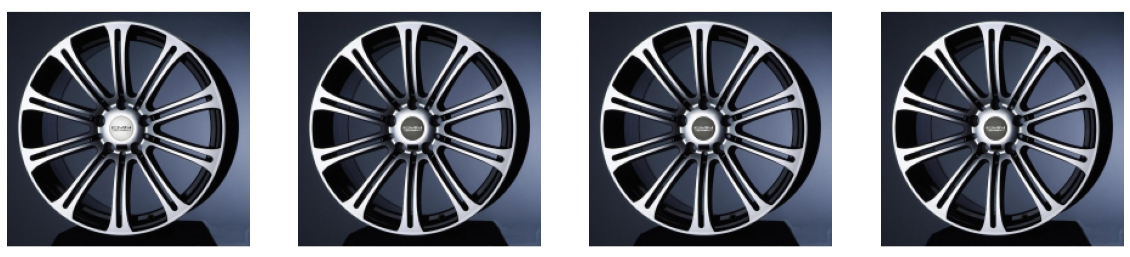

In [20]:
input_img_path = "/content/drive/Shared drives/선빵팀 :) 2/TuningStar_cate/0 (0).jpg"
with tf.device("/GPU:0"):
  find_similar_wheels(vectorizing_model, wheel_pathes, Criteria, input_img_path, validation_matrix)

# 유사도 TOP N개의 휠 추출

In [39]:
def find_topN(N, vectorizing_model,wheel_pathes, input_img_path,validation_matrix):
    # making cosine similarity vector
    img_vector = making_img_vector(vectorizing_model,input_img_path)
    matrix = np.concatenate((img_vector,validation_matrix))
    cosine_sim_vector = cosine_similarity(matrix)[0][1:] # 자기 자신 제외한 나머지와의 코사인 유사도. 순서는 0, 1, 10, ..., 90 순.
    
    # finding Top N wheels
    topN_index = cosine_sim_vector.argsort()[-N:]
    wheel_pathes = np.array(sorted(wheel_pathes))
    similar_wheel_pathes = wheel_pathes[topN_index]
    similar_wheel_pathes = list(similar_wheel_pathes)
    similar_wheel_pathes.reverse()

    # Get Top N wheel_images
    img_list=[]
    for similar_wheel_path in similar_wheel_pathes:
        img = Image.open(similar_wheel_path)
        img_list.append(img)
    
    img_count = len(similar_wheel_pathes)
    plt.figure(figsize=(20,20))
    for i in range(len(img_list)):
        plt.subplot(1, img_count+1, i+2)
        plt.imshow(img_list[i])
        plt.axis("off")
    plt.subplot(1,img_count+1,1)
    plt.imshow(Image.open(input_img_path))
    plt.axis("off")
    plt.show()

In [22]:
vectorizing_model = load_model("/content/drive/Shared drives/선빵팀 :) 2/vectorizing_model_woong.h5")
wheel_pathes = glob.glob("/content/drive/Shared drives/선빵팀 :) 2/TuningStar_cate/*.jpg")
validation_matrix = np.load("/content/drive/Shared drives/선빵팀 :) 2/validation_matrix_woong.npy")

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


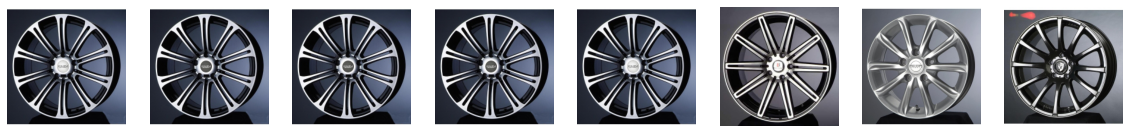

In [40]:
input_img_path = "/content/drive/Shared drives/선빵팀 :) 2/TuningStar_cate/0 (0).jpg"
with tf.device("/GPU:0"):
    find_topN(7,vectorizing_model, wheel_pathes, input_img_path, validation_matrix)